In [60]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Cone
Surface Area:$$ S = \pi r \sqrt{h^2 + r^2}$$

Total Area:$$ T = \pi r (r + \sqrt{h^2 + r^2})$$

Volume:$$ V = \pi r^2 h$$

## Constraints
Radius: $$ r  \epsilon  [0,10] cm $$
Height $$ h \epsilon [0,20] cm $$
Volume: $$ V > 200 cm^3 $$

In [110]:
def surface_area(ch):
    r,h = decode(ch)
    return np.pi*r*np.sqrt(h**2 + r**2)

def total_area(ch):
    r,h = decode(ch)
    return np.pi*(r**2) + surface_area(ch)

def volume(ch):
    r,h = decode(ch)
    return np.pi*(r**2)*h

# Encoding
def encode(r,h):
    r = int(np.round((r*100)*(1023/1000))) # Requires 10 bits
    h = int(np.round((h*100)*(2047/2000))) # Requires 11 bits
    r = bin(r)[2:]
    h = bin(h)[2:]
    r = r if len(r)==10 else ('0'*(10-len(r)) + r) # Padding zeros to left to make strings of equal length
    h = h if len(h)==11 else ('0'*(11-len(h)) + h)
    return r+h # Combined encoding of radius and height


def decode(ch):
    r = ch[:10]
    r = int(r,2)
    r = (r/100)*(1000/1023)
    h = ch[10:]
    h = int(h,2)
    h = (h/100)*(1000/1023)
    return r,h


def crossover(parent1,parent2):
    assert len(parent1) == len(parent2)
    partition = np.random.randint(1,len(parent1))
    child1 = parent1[:partition] + parent2[partition:]
    child2 = parent1[partition:] + parent2[:partition]
    return child1,child2


def mutation(child,mutation_prob = 0.01):
    child = np.array(list(map(int,list(child)))).astype('bool')
    flip_bits = np.random.rand(len(child))<mutation_prob
    child[flip_bits] = ~child[flip_bits]
    child = child.astype(int)
    child = "".join(list(map(str,child)))
    return child



def nds(surface_area,total_area):
    assert len(surface_area)==len(total_area)
    ranks = np.zeros(len(surface_area))
    fronts = [[]]
    while(len(surface_area)>0):
        indices = []
        for i in range(len(surface_area)):
            flag = 0
            for j in range(len(surface_area)):
                if(surface_area[j]<surface_area[i] and total_area[j]<total_area[i]):
                    flag = 1
                    break
            if(flag==0):
                fronts[-1].append((surface_area[i],total_area[i]))
                indices.append(i)
        indices = sorted(indices,reverse=True)
        for i in indices:
            surface_area.pop(i)
            total_area.pop(i)
        fronts.append([])
    return fronts[:-1]

def crowding_distance(fronts,S_max,S_min,T_max,T_min):
    cd = [0]*len(fronts)
    for f in range(len(fronts)):
        if(len(fronts)<=2):
            cd[f] = [np.inf]*len(fronts)
        else:
            cd[f] = [0]*len(fronts[f])
            S_sorted = sorted(fronts[f])
            T_sorted = sorted(fronts[f],key = lambda x:x[1])
            cd[f][fronts[f].index(S_sorted[0])] = np.inf
            cd[f][fronts[f].index(T_sorted[0])] = np.inf
            idx = np.where(np.array(cd[f])==0)[0]
            for i in idx:
                cd[f][i] += (S_sorted[S_sorted.index(fronts[f][i])+1][0] - S_sorted[S_sorted.index(fronts[f][i])-1][0])/(S_max-S_min)
                cd[f][i] += (T_sorted[T_sorted.index(fronts[f][i])+1][1] - T_sorted[T_sorted.index(fronts[f][i])-1][1])/(T_max-T_min)
    return cd
   
def pareto_front(fronts):
    plt.figure(figsize=(15,8))
    for i in range(len(fronts)):
        S = [fronts[i][j][0] for j in range(len(fronts[i]))]
        T = [fronts[i][j][1] for j in range(len(fronts[i]))]
        plt.scatter(S,T)
    plt.xlabel('Surface Area')
    plt.ylabel('Total Area')
    plt.title('Pareto Fronts (Candidates of same colour belong to one front)')
    plt.show()

In [88]:
initial_population = 100
min_volume = 200
mutation_prob = 0.01
max_iterations = 50

parent = []

while(len(parent)<initial_population):
    r_parent = 10*np.random.rand()
    h_parent = 20*np.random.rand()
    if(volume(encode(r_parent,h_parent))>min_volume):
        parent.append(encode(r_parent,h_parent))

for itr in range(max_iterations):
    child = []
    while(len(child)<len(parent)):
        idx = np.random.randint(0,len(parent),2)
        parent1 = parent[idx[0]]
        parent2 = parent[idx[1]]
        child1,child2 = crossover(parent1,parent2)
        child1 = mutation(child1)
        child2 = mutation(child2)
        if(volume(child1)>min_volume):
            child.append(child1)
        if(volume(child2)>min_volume):
            child.append(child2)
    total = parent+child
    equal_count = 0
    for i in range(len(parent)):
        for j in range(len(child)):
             if(parent[i] == child[j]):
                    equal_count += 1

    S = []
    T = []
    V = []
    S_T = []
    for i in range(len(total)):
        S.append(surface_area(total[i]))
        T.append(total_area(total[i]))
        S_T.append((surface_area(total[i]),total_area(total[i])))
        V.append(volume(total[i]))


    fronts = nds(S.copy(),T.copy())
    cd = crowding_distance(fronts,max(S),min(S),max(T),min(T))
    c = 0
    parent = []
    i = 0
    while i<len(fronts) and c < initial_population:
        if(len(fronts[i])<=initial_population-c):
            for j in fronts[i]:
                parent.append(total[S_T.index(j)])
            c += len(fronts[i])
        else:
            for j in range(initial_population-c):
                parent.append(total[S_T.index(fronts[i][np.argmax(cd[i])])])
                c += 1
        i += 1

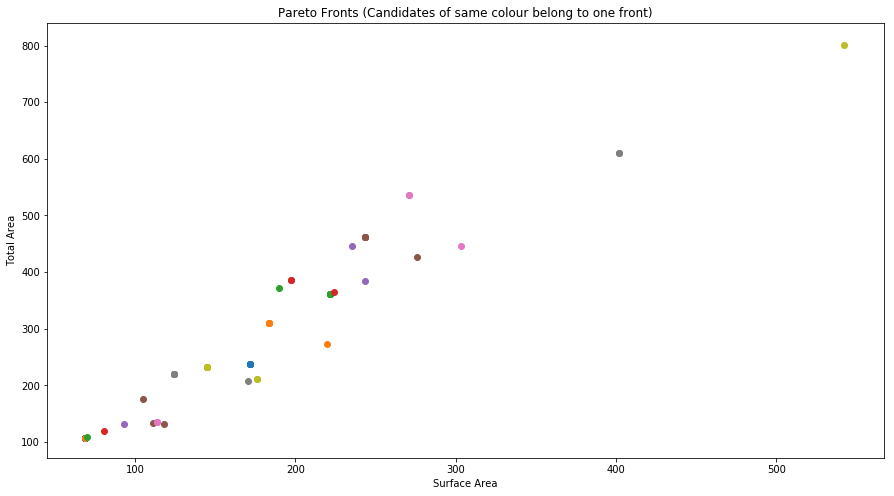

In [111]:
pareto_front(fronts)